In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
!pip install optuna > /dev/null

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [62]:
tf.random.set_seed(47)
np.random.seed(47)

In [63]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [64]:
plt.rcParams['figure.figsize'] = (16,6)

In [65]:
from google.colab import files
uploaded = files.upload()

Saving TSLA.csv to TSLA.csv


In [66]:
df = pd.read_csv('TSLA.csv')
df['Date'] = pd.to_datetime(df.Date)

In [67]:
# Include only the desired columns (Open, Close, Low, High, Adj Close) and drop 'Volume'
df = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']]

# Optionally, you can rename the columns for consistency
df.columns = ['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']

# Display the first few rows of the updated DataFrame
print(df.head())

        Date      Open     Close       Low      High  Adj Close
0 2010-06-30  1.719333  1.588667  1.553333  2.028000   1.588667
1 2010-07-01  1.666667  1.464000  1.351333  1.728000   1.464000
2 2010-07-02  1.533333  1.280000  1.247333  1.540000   1.280000
3 2010-07-06  1.333333  1.074000  1.055333  1.333333   1.074000
4 2010-07-07  1.093333  1.053333  0.998667  1.108667   1.053333


In [68]:
df.describe()

,Date,Open,Close,Low,High,Adj Close
count,2517,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000
mean,2015-06-29 05:56:59.785458944,13.955006,13.959509,13.674515,14.226839,13.959509
min,2010-06-30 00:00:00,1.076000,1.053333,0.998667,1.108667,1.053333
25%,2012-12-28 00:00:00,2.334667,2.338667,2.301333,2.370000,2.338667
50%,2015-06-30 00:00:00,14.520000,14.527333,14.274667,14.757333,14.527333
75%,2017-12-27 00:00:00,18.868668,18.941334,18.511333,19.202667,18.941334
max,2020-06-29 00:00:00,67.518669,68.336670,66.297997,68.498665,68.336670
std,NaN,10.972935,10.979453,10.701203,11.237751,10.979453


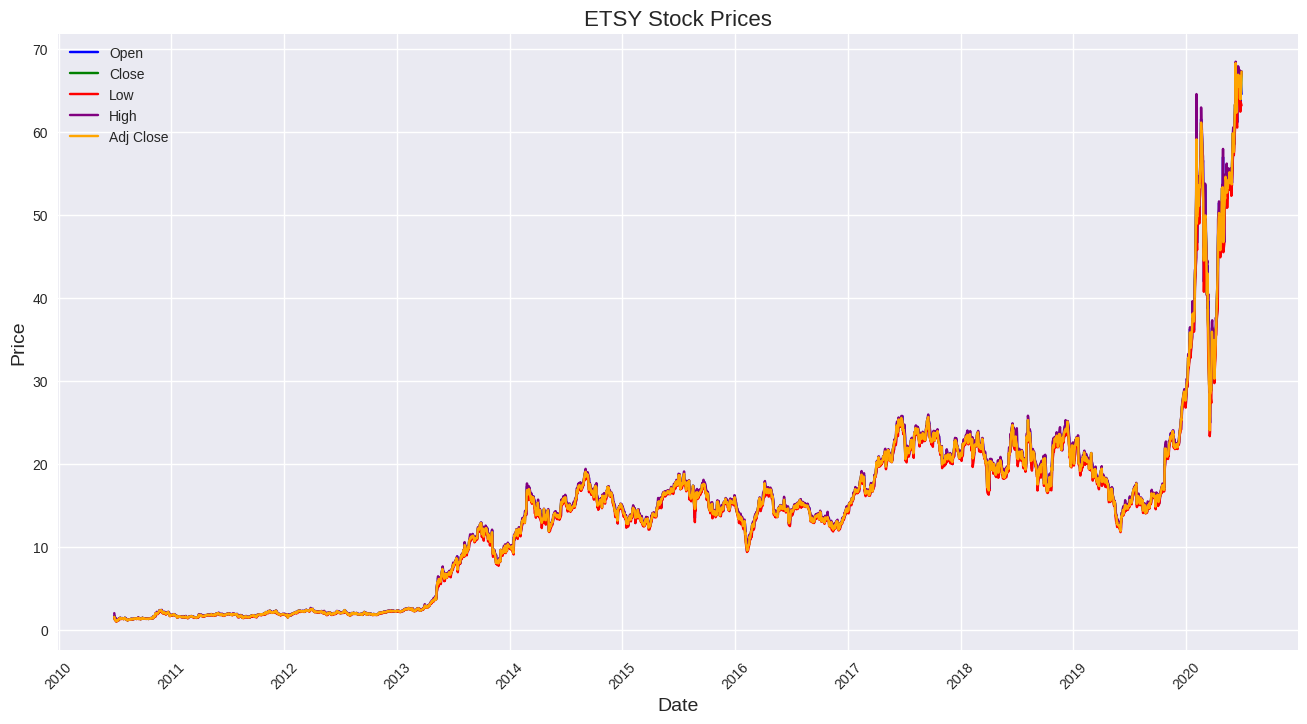

In [69]:
plt.figure(figsize=(16, 8))  # Set the figure size

plt.title('ETSY Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Plot all price columns
plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='green')
plt.plot(df['Date'], df['Low'], label='Low', color='red')
plt.plot(df['Date'], df['High'], label='High', color='purple')
plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='orange')

plt.legend()  # Show legend
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Show grid
plt.show()

In [70]:
# Calculate the average price for each day
df['avg_price'] = df[['Open', 'Close', 'Low', 'High', 'Adj Close']].mean(axis=1)

# Calculate percentage change based on the average price
df['returns'] = df['avg_price'].pct_change() * 100

# Drop any rows with missing values generated by pct_change()
df.dropna(inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify the changes
print(df.head())

        Date      Open     Close       Low      High  Adj Close  avg_price  \
0 2010-07-01  1.666667  1.464000  1.351333  1.728000   1.464000   1.534800   
1 2010-07-02  1.533333  1.280000  1.247333  1.540000   1.280000   1.376133   
2 2010-07-06  1.333333  1.074000  1.055333  1.333333   1.074000   1.174000   
3 2010-07-07  1.093333  1.053333  0.998667  1.108667   1.053333   1.061467   
4 2010-07-08  1.076000  1.164000  1.038000  1.168000   1.164000   1.122000   

     returns  
0  -9.483369  
1 -10.337946  
2 -14.688505  
3  -9.585453  
4   5.702808  


In [72]:
# Create a new DataFrame 'data' with all price features and returns
data = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close', 'returns']]

# Display the first few rows of the new DataFrame
print(data.head())

        Date      Open     Close       Low      High  Adj Close    returns
0 2010-07-01  1.666667  1.464000  1.351333  1.728000   1.464000  -9.483369
1 2010-07-02  1.533333  1.280000  1.247333  1.540000   1.280000 -10.337946
2 2010-07-06  1.333333  1.074000  1.055333  1.333333   1.074000 -14.688505
3 2010-07-07  1.093333  1.053333  0.998667  1.108667   1.053333  -9.585453
4 2010-07-08  1.076000  1.164000  1.038000  1.168000   1.164000   5.702808


In [73]:
# Convert the 'data' DataFrame to a NumPy array
data_array = data.values

# Display the shape of the array
print("Shape of the NumPy array:", data_array.shape)

# Optionally, display the array
print(data_array)

Shape of the NumPy array: (2516, 7)
[[Timestamp('2010-07-01 00:00:00') 1.666667 1.464 ... 1.728 1.464
  -9.483368719037522]
 [Timestamp('2010-07-02 00:00:00') 1.533333 1.28 ... 1.54 1.28
  -10.337946312223078]
 [Timestamp('2010-07-06 00:00:00') 1.333333 1.074 ... 1.333333 1.074
  -14.688505444095101]
 ...
 [Timestamp('2020-06-25 00:00:00') 63.618 65.732002 ... 65.732002
  65.732002 -0.42034116482752015]
 [Timestamp('2020-06-26 00:00:00') 66.318665 63.982666 ... 66.333336
  63.982666 0.3045751357298121]
 [Timestamp('2020-06-29 00:00:00') 64.60067 67.290001 ... 67.333336
  67.290001 1.687869050194224]]


In [74]:
# Drop the 'Date' column from the DataFrame
data = data.drop('Date', axis=1).values

# Display the shape of the array
print("Shape of the NumPy array:", data.shape)

# Optionally, display the array
print(data)

Shape of the NumPy array: (2516, 6)
[[  1.666667     1.464        1.351333     1.728        1.464
   -9.48336872]
 [  1.533333     1.28         1.247333     1.54         1.28
  -10.33794631]
 [  1.333333     1.074        1.055333     1.333333     1.074
  -14.68850544]
 ...
 [ 63.618       65.732002    62.476665    65.732002    65.732002
   -0.42034116]
 [ 66.318665    63.982666    63.658001    66.333336    63.982666
    0.30457514]
 [ 64.60067     67.290001    63.234669    67.333336    67.290001
    1.68786905]]


In [75]:
from sklearn.model_selection import train_test_split

In [76]:
X_train, X_data = train_test_split(data, test_size=0.05, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(2390, 6)
(63, 6)
(63, 6)


In [77]:
from sklearn.preprocessing import MinMaxScaler

In [78]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [79]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [80]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)

Train Samples: 2389
Validation Samples: 62
Test Samples: 62


In [81]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [82]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(2389,) (62,) (62,)


In [83]:
x_train[1], y_train[0]

(array([[0.01637778, 0.00819002, 0.00906724, 0.01545332, 0.00819002,
         0.11510835]]),
 0.016377775390345226)

In [84]:
x_val[1], y_val[0]

(array([[0.92837702, 0.96962466, 0.94100201, 0.96651383, 0.96962466,
         0.34897898]]),
 0.9283770233490903)

In [85]:
x_test[1], y_test[0]

(array([[1.16473277, 1.12193474, 1.11850646, 1.1878284 , 1.12193474,
         0.25268342]]),
 1.1647327746741154)

In [86]:
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [87]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D, Dense, Dropout, Reshape, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np

In [88]:
%%time
# Define EarlyStopping callback
early_stopping_rounds = EarlyStopping(monitor='loss', patience=50)

def run(trial):
    space = {
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'epochs': trial.suggest_int('epochs', 50, 200),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }

    n_timesteps = x_train.shape[1]  # Assuming x_train is your input data
    n_features = x_train.shape[2]

    x_train_reshaped = x_train.reshape((x_train.shape[0], n_timesteps, 1, n_features, 1))
    x_val_reshaped = x_val.reshape((x_val.shape[0], n_timesteps, 1, n_features, 1))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         input_shape=(n_timesteps, 1, n_features, 1),
                         return_sequences=True, padding='same'))

    model.add(Reshape((-1, 64)))
    model.add(Flatten())
    # Change the number of units in the Dense layer to match the shape of y_train or y_val
    model.add(Dense(units=1))  # Output a single value for each input
    model.add(Dropout(0.2))

    if space['optimizer'] == 'Adam':
        optimizer = optimizers.Adam(learning_rate=space['learning_rate'])
    else:
        optimizer = optimizers.RMSprop(learning_rate=space['learning_rate'])

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    model.fit(x_train_reshaped, y_train, epochs=space['epochs'], validation_data=(x_val_reshaped, y_val),
              batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_val = model.predict(x_val_reshaped)

    rmse = mean_squared_error(y_val, yhat_val, squared=False) if not np.isnan(yhat_val).any() else 99999
    return rmse

# Hyperparameter Optimization with Conv LSTM
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=10, n_jobs=-1)
print('Best trial: {}'.format(study.best_trial))

[I 2024-07-03 10:47:42,994] A new study created in memory with name: no-name-d89ed04b-d4e3-424f-b05f-4a86e4f5fc9d


2/2 [==============================] - 0s 77ms/step


[I 2024-07-03 10:48:39,203] Trial 1 finished with value: 0.21405969143029183 and parameters: {'optimizer': 'Adam', 'learning_rate': 6.15895817041046e-05, 'epochs': 171, 'batch_size': 64}. Best is trial 1 with value: 0.21405969143029183.


2/2 [==============================] - 1s 16ms/step


[I 2024-07-03 10:49:24,304] Trial 2 finished with value: 0.32498526192688 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0031793928799656477, 'epochs': 154, 'batch_size': 64}. Best is trial 1 with value: 0.21405969143029183.


2/2 [==============================] - 0s 11ms/step


[I 2024-07-03 10:50:09,805] Trial 3 finished with value: 0.2823875123794898 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 8.879138614762257e-05, 'epochs': 72, 'batch_size': 32}. Best is trial 1 with value: 0.21405969143029183.


2/2 [==============================] - 1s 6ms/step


[I 2024-07-03 10:51:21,869] Trial 0 finished with value: 0.29432483028050505 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 1.479576179820197e-05, 'epochs': 118, 'batch_size': 16}. Best is trial 1 with value: 0.21405969143029183.


2/2 [==============================] - 0s 9ms/step


[I 2024-07-03 10:51:22,165] Trial 4 finished with value: 0.29235913630649124 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00046870906219984525, 'epochs': 80, 'batch_size': 32}. Best is trial 1 with value: 0.21405969143029183.


2/2 [==============================] - 0s 8ms/step


[I 2024-07-03 10:52:16,374] Trial 6 finished with value: 0.31951437020045503 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00042488024701953366, 'epochs': 140, 'batch_size': 16}. Best is trial 1 with value: 0.21405969143029183.


2/2 [==============================] - 0s 9ms/step


[I 2024-07-03 10:52:45,284] Trial 7 finished with value: 0.2776580244990061 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0004496421154521442, 'epochs': 57, 'batch_size': 32}. Best is trial 1 with value: 0.21405969143029183.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-03 10:53:48,655] Trial 5 finished with value: 0.2923229898720265 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 1.3480849175368806e-05, 'epochs': 193, 'batch_size': 64}. Best is trial 1 with value: 0.21405969143029183.


2/2 [==============================] - 1s 10ms/step


[I 2024-07-03 10:54:11,409] Trial 8 finished with value: 0.29356331101870553 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 1.718228785496613e-05, 'epochs': 54, 'batch_size': 16}. Best is trial 1 with value: 0.21405969143029183.


2/2 [==============================] - 0s 4ms/step


[I 2024-07-03 10:55:23,227] Trial 9 finished with value: 0.38703745414867274 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.008908729195755371, 'epochs': 162, 'batch_size': 32}. Best is trial 1 with value: 0.21405969143029183.


Best trial: FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.21405969143029183], datetime_start=datetime.datetime(2024, 7, 3, 10, 47, 43, 4615), datetime_complete=datetime.datetime(2024, 7, 3, 10, 48, 39, 202955), params={'optimizer': 'Adam', 'learning_rate': 6.15895817041046e-05, 'epochs': 171, 'batch_size': 64}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'epochs': IntDistribution(high=200, log=False, low=50, step=1), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=1, value=None)
CPU times: user 10min 51s, sys: 46.9 s, total: 11min 38s
Wall time: 7min 40s


In [89]:
best_params = study.best_params
best_params

{'optimizer': 'Adam',
 'learning_rate': 6.15895817041046e-05,
 'epochs': 171,
 'batch_size': 64}

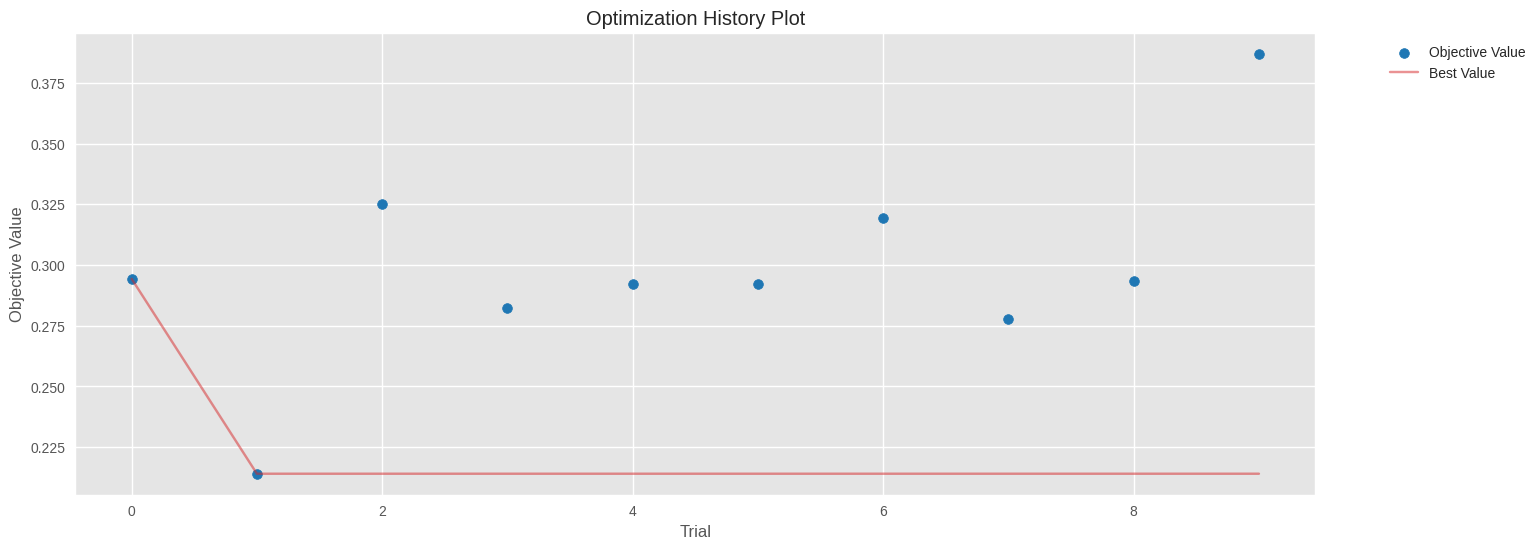

In [90]:
plot_optimization_history(study);

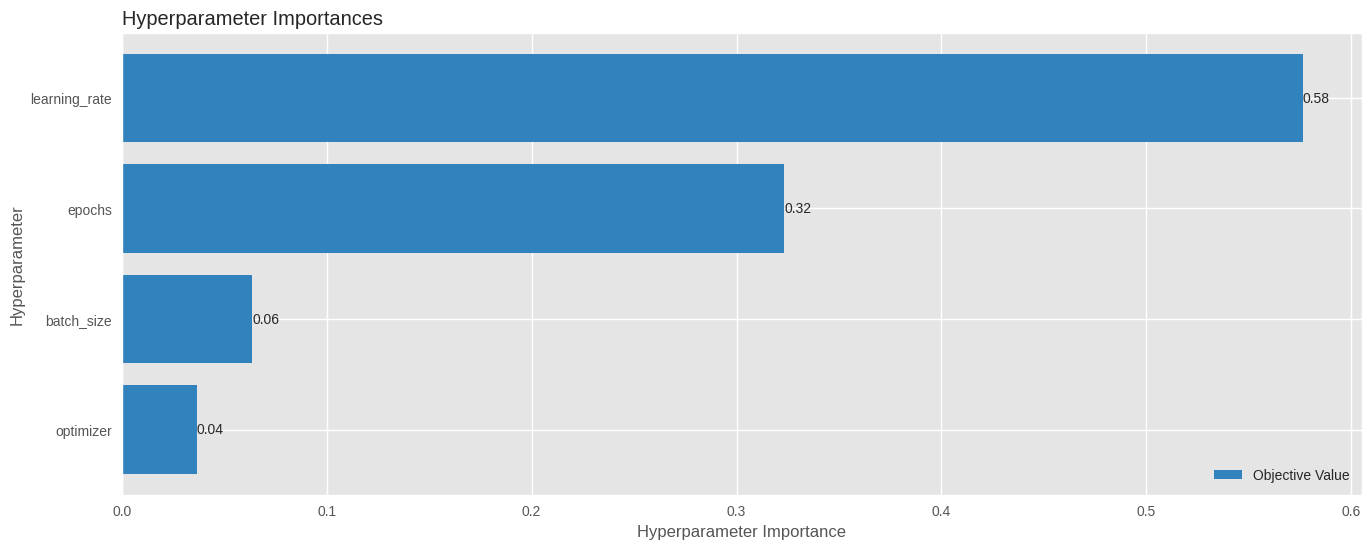

In [91]:
plot_param_importances(study);

In [92]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

In [93]:
# Define the LSTM model using the best hyperparameters
model = Sequential()
# Check if 'units' is in best_params, if not, provide a default value
units = best_params.get("units", 64)  # Default to 64 units if not found
model.add(LSTM(units=units, input_shape=(x_train.shape[1], x_train.shape[2])))

# Check if 'dropout_rate' exists in best_params before using it
if 'dropout_rate' in best_params:
    model.add(Dropout(rate=best_params["dropout_rate"]))

model.add(Dense(units=1))

# Compile the model with the best optimizer and learning rate
if best_params['optimizer'] == 'Adam':
    optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = optimizers.RMSprop(learning_rate=best_params['learning_rate'])

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


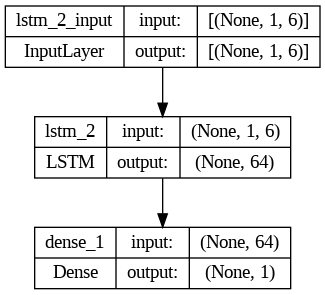

In [94]:
plot_model(model, show_shapes=True)

In [95]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 34.1 s, sys: 2.3 s, total: 36.4 s
Wall time: 42.4 s


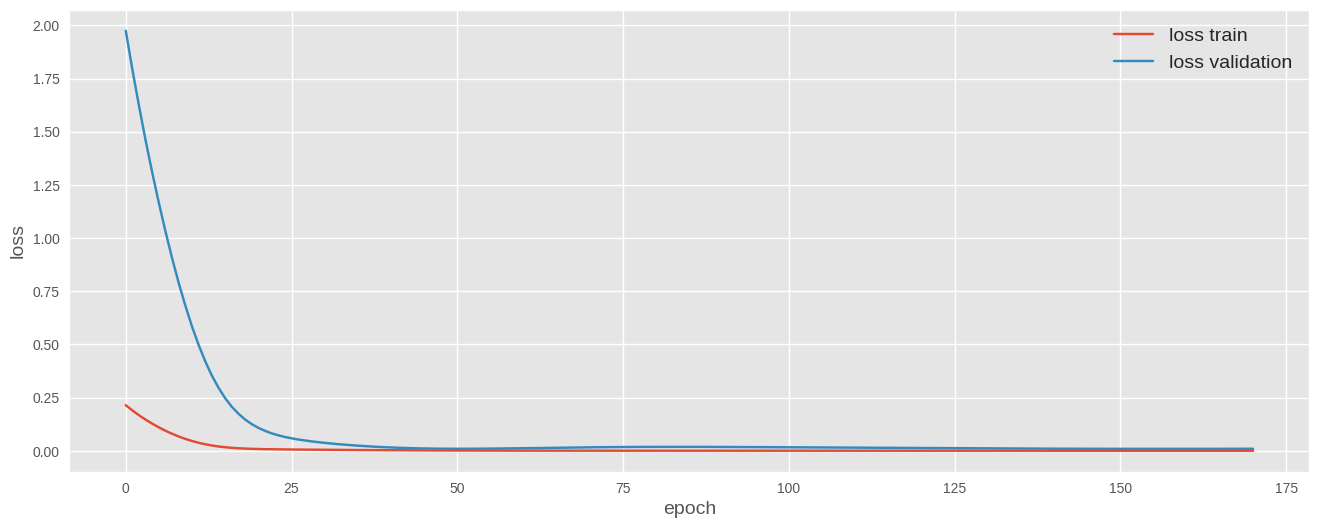

In [96]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [97]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

1/1 [==============================] - 0s 25ms/step - loss: 0.0107 - accuracy: 0.0000e+00


[0.010704996064305305, 0.0]

In [98]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

2/2 [==============================] - 0s 5ms/step


In [99]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(2389,) (62,)


In [100]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [1.70158241 1.55911387 1.39186509 1.27923756 1.23119281]
Train Actual:  [2. 1. 1. 1. 1.]
Test Predicted:  [34.79024489 32.67489223 31.01625428 33.07806985 34.54661001]
Test Actual:  [34. 32. 34. 34. 36.]


In [101]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.41 RMSE
Test Score: 2.92 RMSE


In [102]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

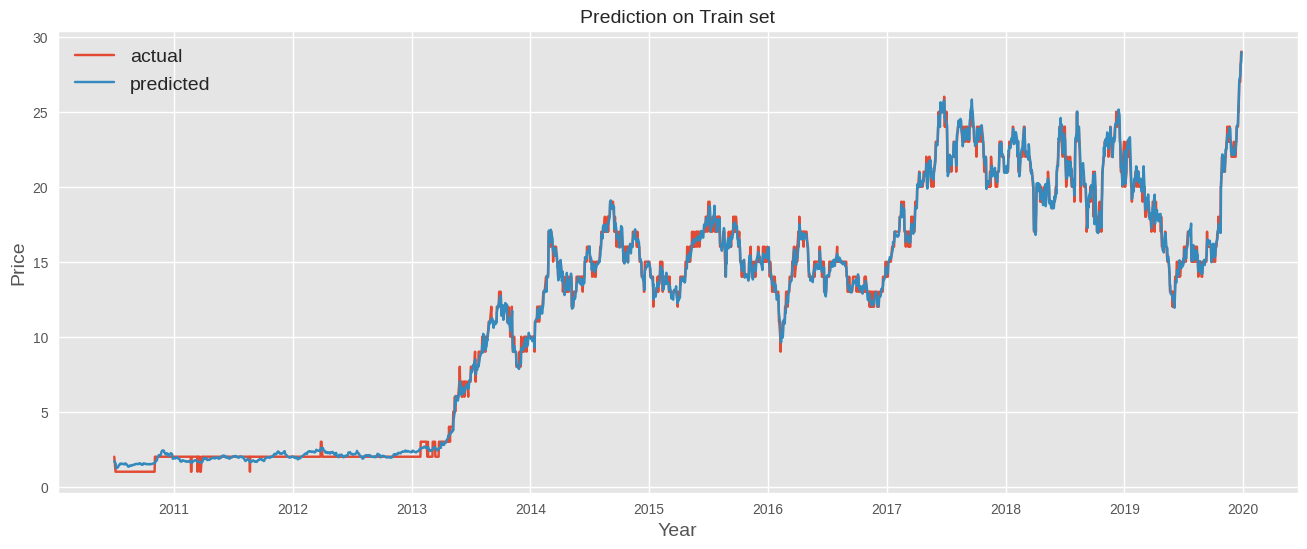

In [103]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

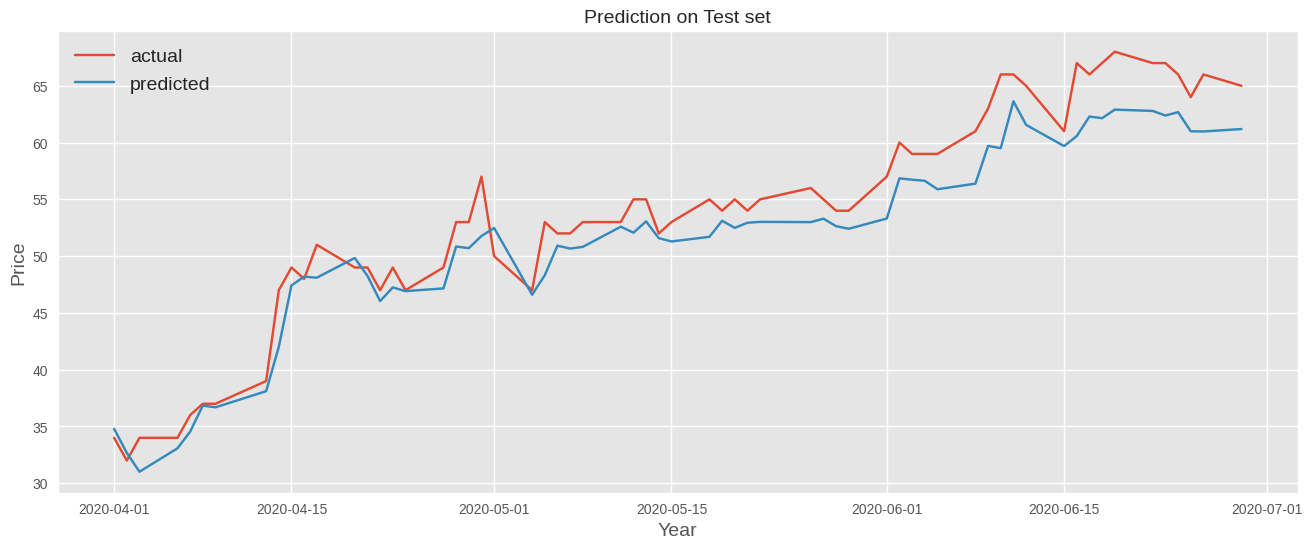

In [104]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()

In [105]:
yhat_test

array([34.79024489, 32.67489223, 31.01625428, 33.07806985, 34.54661001,
       36.83701096, 36.68828017, 38.10782371, 42.00985995, 47.42016225,
       48.19208771, 48.09979007, 49.83759687, 48.26413626, 46.0443092 ,
       47.24681498, 46.91904133, 47.15796597, 50.85033773, 50.70073812,
       51.77142007, 52.47676953, 46.6018899 , 48.32223714, 50.92414389,
       50.66611527, 50.81580808, 52.5931111 , 52.06333921, 53.06088076,
       51.58483416, 51.29180321, 51.70074964, 53.11516018, 52.4887399 ,
       52.94055462, 53.01706377, 52.99499715, 53.2979213 , 52.63806988,
       52.41028341, 53.31112998, 56.84853943, 56.73113597, 56.63474391,
       55.89029103, 56.38372907, 59.70385442, 59.51105031, 63.63396243,
       61.56043947, 59.69123161, 60.57697208, 62.29306845, 62.14821238,
       62.90260505, 62.78577748, 62.38255326, 62.67960873, 60.99490295,
       60.97755324, 61.19240066])

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_test' contains actual values and 'yhat_test' contains predicted values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, yhat_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, yhat_test)

# Calculate R-squared (R2) score
r2 = r2_score(Y_test, yhat_test)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test - yhat_test) / Y_test)) * 100

# Display the Mean Absolute Percentage Error (MAPE)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 8.50320571005011
Root Mean Squared Error (RMSE): 2.9160256703345584
Mean Absolute Error (MAE): 2.4330887400796337
R-squared (R2) Score: 0.9034619881287339
Mean Absolute Percentage Error (MAPE): 4.31%


In [107]:
# Assuming 'Y_train' contains actual values and 'yhat_train' contains predicted values

# Calculate Mean Absolute Percentage Error (MAPE)
mape_train = np.mean(np.abs((Y_train - yhat_train) / Y_train)) * 100

# Display the Mean Absolute Percentage Error (MAPE) for the training set
print(f'Mean Absolute Percentage Error (MAPE) on Training set: {mape_train:.2f}%')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_train' contains the actual values and 'yhat_train' contains the predicted values for the training set

# Calculate Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(Y_train, yhat_train)

# Calculate Root Mean Squared Error (RMSE) on the training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(Y_train, yhat_train)

# Calculate R-squared (R2) score on the training set
r2_train = r2_score(Y_train, yhat_train)

# Display the accuracy metrics for the training set
print(f'Mean Squared Error (MSE) on Training set: {mse_train:.2f}')
print(f'Root Mean Squared Error (RMSE) on Training set: {rmse_train:.2f}')
print(f'Mean Absolute Error (MAE) on Training set: {mae_train:.2f}')
print(f'R-squared (R2) Score on Training set: {r2_train:.2f}')

Mean Absolute Percentage Error (MAPE) on Training set: 5.91%
Mean Squared Error (MSE) on Training set: 0.16
Root Mean Squared Error (RMSE) on Training set: 0.41
Mean Absolute Error (MAE) on Training set: 0.31
R-squared (R2) Score on Training set: 1.00


In [108]:
import numpy as np

def calculate_forecast_accuracy(yhat_test, Y_test):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_test - Y_test) / Y_test
    return accuracy

# Compute forecast accuracy for the test set
forecast_accuracy = calculate_forecast_accuracy(yhat_test, Y_test)

# Calculate the mean accuracy across all data points
mean_accuracy = np.mean(forecast_accuracy)

print(f'Mean Forecast Accuracy on Test Set: {mean_accuracy:.2f}')

Mean Forecast Accuracy on Test Set: 0.96


In [109]:
def calculate_forecast_accuracy(yhat_train, Y_train):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_train - Y_train) / Y_train
    return accuracy

# Compute forecast accuracy for the training set
forecast_accuracy_train = calculate_forecast_accuracy(yhat_train, Y_train)

# Calculate the mean accuracy across all data points
mean_accuracy_train = np.mean(forecast_accuracy_train)

print(f'Mean Forecast Accuracy on Training Set: {mean_accuracy_train:.2f}')

Mean Forecast Accuracy on Training Set: 0.94
